# Proyecto 04 - Análisis de mercado inmobiliario

#### En este último Sprint me propuse como desafio, evaluar un Modelo de Machine Learning para calcular el valor de cualquier tipo de inmueble, teniendo en cuenta su ubicacion geografica.

### Etapas que este proyecto debe seguir:

1. Preprocesar los datos originales teniendo en cuenta su georeferenciación para hacer un mapa con la distribucion espacial de las propiedades.
2. Graficar un HeatMap para poder apreciar las zonas de mayor concentración de propiedades.
3. Validar la precencia de Outliers.
4. Hacer una visualización para definir las zonas de propiedades de mayor valor, y las de menor valor.
5. Entrenar un nuevo modelo de Machine Learning.
6. Optimizar un Hiperparametro.
7. Graficar la distribución espacial de los errores de predicción.
8. Proponer una estrategia adicional para mejorar el modelo.
9. Ejemplificar el precio de dos propiedades 


### ----------------------------------------------------------------- 

### Link al repositorio donde se encuentra alojado el proyecto. <br>

- https://github.com/outaCtrl/DataScience.git

### ------------------------------------------------------------------


## Parte 1 <br>

---------------------------------------------------------------------------

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

# libreria para el mapa.
import folium
from folium.plugins import HeatMap #importar modulo de mapa de calor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Importo la libreria para evitar mostrar warning en el notebook
import warnings
warnings.filterwarnings("ignore")

In [63]:
# La siguiente línea es para ver las imagenes dentro del notebook
%matplotlib inline
# Configuramos el tamaño de las figuras
plt.rcParams['figure.figsize'] = (13,9)

In [64]:
# Cargo el DataSet
df = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv", parse_dates = ["created_on"])

<br>

#### Elimino las celdas que no tengan datos en los atributos (latitud y longitud). <br>


In [65]:
# Antes de seguir Voy a Verificar si existe algun registro sin datos

# Valido las dimensiones del DataSet original
(registros_antes,columnas_antes)=(df.shape)

# elimino los registros sin datos 
df.lon = df.lon.replace(['NA'],np.nan)
df = df[~df.lon.isna()]

# Valido las dimensiones del DataSet modificado
(registros_despues,columnas_despues)=(df.shape)

# Comparo la cantidad de registros del DataSet Original y el modificado.
print('')
if registros_antes==registros_despues:
    print('El DataSet no requiere ser depurado por Registros')
else:
    print('Fueron eliminados ',registros_antes-registros_despues,'registros del DataSet Original')
    
print('El DataSet actual cuenta con: ', registros_despues, 'registros')



Fueron eliminados  9959 registros del DataSet Original
El DataSet actual cuenta con:  136701 registros


<br>

#### Valido cuantas clases hay (provincias) en el DataSet depurado.<br>


In [66]:
df['l2'].value_counts()

Capital Federal             87931
Bs.As. G.B.A. Zona Norte    20730
Bs.As. G.B.A. Zona Sur      16202
Bs.As. G.B.A. Zona Oeste    11838
Name: l2, dtype: int64

<br>

#### Ahora, toca implementar un filtro solo con las propiedades que esten ubicadas en Buenas Aires "CAPITAL FEDERAL" y crear un DataFrame que se llame df1.<br>


In [67]:
#Filtro para provincias
df1=df[df['l2']=='Capital Federal']
print('Nuestro datasets solo con la Provincia de Buenas Aires tiene', df1.shape[0],' registros')

Nuestro datasets solo con la Provincia de Buenas Aires tiene 87931  registros


<br>

#### Ahora me queda construir un gráfico inicial que nos diga como es la distribuciòn en el mapa de nuestros puntos. Para ello, haremos un grafico de dispersión o scatterplot colocando en el eje x (longitud) y en el eje y (latitud).<br>


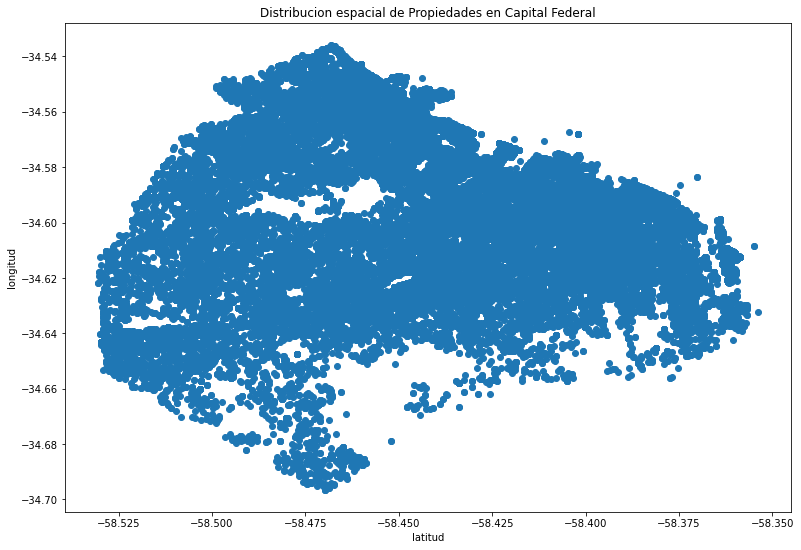

In [68]:
# Creo los conjuntos de coordenadas a plotear
y=df1['lat']
x=df1['lon']

# Defino el tipo de Gràfico
plt.scatter(x,y)
plt.xlabel('latitud');plt.ylabel('longitud')
plt.title('Distribucion espacial de Propiedades en Capital Federal')
plt.show()

#### Luego de aplicar filtros para eliminar celdas sin datos , se obtuvo el mapa de puntos que se muestra considerando solo Capital Federal. Se muestra claramente como se distribuyen los datos y se aprecian zonas con escasos datos y algunas zonas de alta concentracion de datos donde por supuesto la calidad de la predicción deberia ser mayor. 
<br>

### La idea general es poder entrenar un modelo para predecir el precio de cualquier inmueble de esta Provincia, solamente ingresando las coordenadas (latitud y longitud) de dicho inmueble.<br>


## Parte 2:<br>

---------------------------------------------------------------------------

#### Voy a utilizar la libreria Folium para crear un mapa georeferenciado donde incluiremos los puntos que forman parte del dataset que ya depure previamente.

<br>

In [69]:
# calculo las coordenadas del centro del mapa
lat_centro_map=df1['lat'].mean() #promedio de las coordenadas latitud
lon_centro_map=df1['lon'].mean() #promedio de las coordenadas longitud

# cro una pequeña lista con las coordenadas del centro del mapa
Capital_Federal_location = [lat_centro_map, lon_centro_map]

# Creo el objeto m (mapa) y le paso como parametros el centro y el zoom que necesito
m = folium.Map(location=Capital_Federal_location, zoom_start=14)

# Se Extraen los puntos de coordenadas de todos los inmuebles en una lista llamada datos
datos=[] # se crea la lista vacia
for x,y in zip(df1.iloc[:,3],df1.iloc[:,4]):
   datos.append([x,y])

# Creo el mapa de Calor y añado al objeto mapa que ya habia creado
HeatMap(datos).add_to(m)

# Imprimo el mapa de calor resultante
m

#### Este mapa de calor permite apreciar las areas donde tenemos buena cantidad de datos disponibles y las zonas donde es necesario recabar mas información sobre los precios. <br>



## Parte 3:<br>

--------------------------------------------------------------------------- 

#### Calculare los parametros estadísticos (enfocados en las medidas de tendencia central), y a partir de alli y del analisis gráfico , aplicare un procedimiento de eliminacion de datos atípicos.

In [70]:
# calculo la media
media = df1.price.mean()

# calculo de desviacion
std = df1.price.std()

# calculo el minimo usando 3 veces la desviacion 
minimo = media - 3*std

# calculo el maximo usando 3 veces la desviacion 
maximo = media + 3*std

# guardo los parametros en una lista
estadistica=[media,std,minimo, maximo]
names=['Valor Medio=','Desviacion=','Minimo=','Maximo=']

#impresion de estadisticas
print('Los parametros de dispersion son: ')
for nombre, dato in zip(names,estadistica):
    print(nombre,dato)
    
# Calculo el coeficiente de Variacion para ver el grado de dispersion relativa
cv = df1["price"].std(ddof=0) / df1["price"].mean()
print('')
print('El coeficiente variacion es de :',cv)

Los parametros de dispersion son: 
Valor Medio= 254458.32026247855
Desviacion= 338052.6176621193
Minimo= -759699.5327238793
Maximo= 1268616.1732488363

El coeficiente variacion es de : 1.3285110702892784


#### La desviacion standard es considerable. Por otro lado, el coeficiente de variacion es bastante alto inclusive superior a 1, por lo tanto procedemos aplicar los filtros para eliminar outliers.<br>

#### Ahora Grafico el histograma de frecuencias de los datos.

Text(0, 0.5, 'FRECUENCIA price')

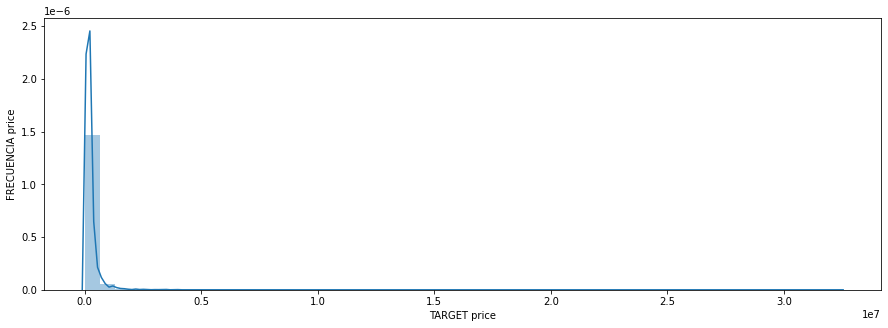

In [71]:
# Grafica de nuestros datos
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(df1.price)
ax.set_xlabel('TARGET price')
ax.set_ylabel('FRECUENCIA price')

#### Claramente se aprecia una asimetria fuerte en el histograma, por eso vamos eliminar algunos puntos anomalos aplicando el siguiente método:

Teniamos  87931 registros
Quedaron  86610 registros


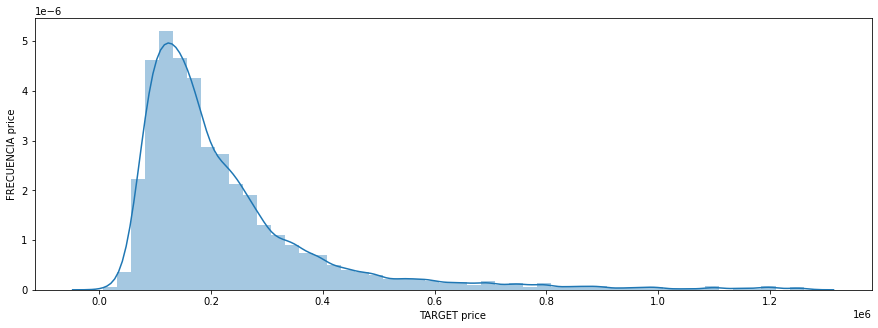

In [72]:
# Construyo una mascara para filtrar outliers

# Este seria el DataSet 
print('Teniamos ',df1.shape[0], 'registros')

# creo mascara
outliers_mask= df1.price < maximo
# Aplico el filtro al DataSet 
df1 = df1[outliers_mask]

# Procedo a graficar el historgrama con el nuevo datasets
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(df1.price)
ax.set_xlabel('TARGET price')
ax.set_ylabel('FRECUENCIA price')

# Este seria el DataSet final
print('Quedaron ',df1.shape[0], 'registros')

#### Se vuelven a calcular los parámetros de dispersión, y se hace énfasis en el parametro coeficiente de variación.

In [73]:
# calculo la media
media = df1.price.mean()

# calculo de desviacion
std = df1.price.std()

# calculo el minimo usando 3 veces la desviacion 
minimo = media - 3*std

# calculo el maximo usando 3 veces la desviacion 
maximo = media + 3*std

# guardo los parametros en una lista
estadistica=[media,std,minimo, maximo]

names=['Valor Medio=','Desviacion=','Minimo=','Maximo=']

#impresion de estadisticas
print('Los parametros de dispersión son: ')
for nombre, dato in zip(names,estadistica):
    print(nombre,dato)

# Calculo el coeficiente de Variacion para ver el grado de dispersion relativa
cv2 = df1["price"].std(ddof=0) / df1["price"].mean()
print('')
print('El coeficiente variacion es de :',cv2)

Los parametros de dispersión son: 
Valor Medio= 226417.65612515877
Desviacion= 173722.36859177472
Minimo= -294749.4496501654
Maximo= 747584.7619004829

El coeficiente variacion es de : 0.7672606839135983


#### Realizo un grafico comparativo con los dos valores del coeficiente de variacion antes y despues del proceso de preprocesamiento

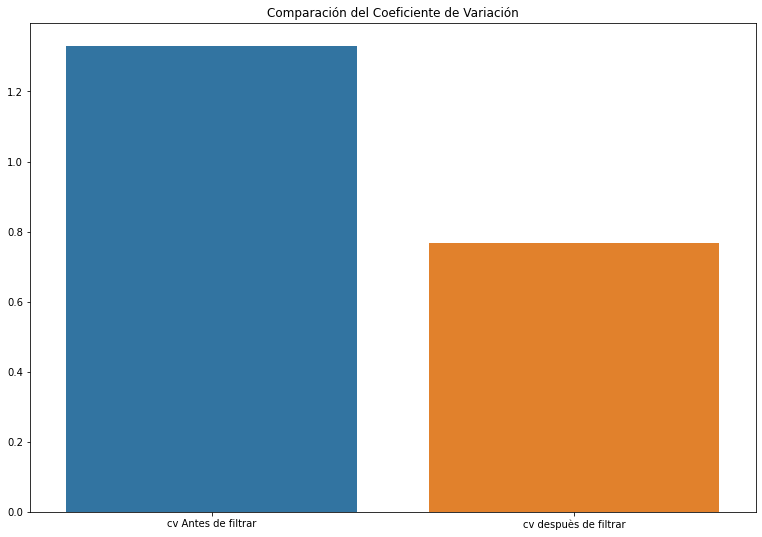

In [74]:
x = ['cv Antes de filtrar', 'cv despuès de filtrar']
y = [cv, cv2]

# Genera el grafico de barras
sns.barplot(x, y).set_title('Comparación del Coeficiente de Variación')

plt.show()


<br>

#### En el grafico se puede observar la importancia que tiene la eliminacion de datos atípicos en cualquier dataset. En este caso cobra mayor importancia ya que nos conviene que las variaciones de precios entre una y otra edificación, sea leve o uniforme en el espacio y no ocurran variaciones tan abruptas en pequeñas distancias. En resumen, es mejor disponer de una base de datos que presente cierta sectorización espacial en función de los precios.<br>



## Parte 4:<br>

---------------------------------------------------------------------------

#### Debo crear un nuevo DataSet con una nueva columna (rango) que tenga una categoria de precio facil de entender, tal como se muestra a continuacion.

In [75]:
#Se crea el DataSet
dataset=pd.DataFrame()

# Asignolas columnas de geolocalizacion latitud y longitud de cada inmueble asi como el precio
dataset['lat']=df1['lat']
dataset['lon']=df1['lon']
dataset['price']=df1['price']

# El nuevo DataSet es el siguiente
dataset.head()

lat        lon     price
0 -34.605880 -58.384949  153000.0
1 -34.624056 -58.412110  159000.0
2 -34.593569 -58.427474  125000.0
3 -34.581294 -58.436754  295000.0
5 -34.593779 -58.441239  150000.0

In [76]:
print('El precio maximo es de ', dataset['price'].max())
print('El Precio minimo es de ', dataset['price'].min())

El precio maximo es de  1260000.0
El Precio minimo es de  6000.0


#### Ahora procedo a calcular los rangos de precios en funcion de 9 clases (espaciadas a iguales intervalos de precio) 
<br>

#### ***Etiquetas*** = ['muy barato', 'barato', 'muy economico', 'económico', 'medio','medio alto', 'caro', 'muy caro', 'demasiado caro',]<br>



In [77]:
#numero de intervalos a dividir el rango de precios
num_intervalos=9

#espaciado de precios a iguales intervalos
espaciado= ( dataset['price'].max()- dataset['price'].min() ) /num_intervalos

#Crear rango de Calificaciones en funcion del costo y asiganr color para Graficar
# Primero creo la lista con los rangos limites para cada intervalo
bins=[ int for int in range(0,int(dataset['price'].max()), int(espaciado)) ]

# Reemplazo el ultimo elemento de la lista por el valor maximo del rango para asegurar que ningun precio quede fuera
bins[-1]=dataset['price'].max()+1
 
# Agrupo las etiquetas correspondientes, cada categoria corresponde a un rango de precios...
etiquetas = ['muy barato', 'barato', 'muy economico', 'económico',
             'medio','medio alto', 'caro', 'muy caro', 'demasiado caro',]

# imprimir los rangos de precios 
print('Rangos de precios para clasificar cada inmueble:')
print(bins)

# imprimir etiquetas
print('Etiquetas para clasificar cada inmueble:')
print(etiquetas)

Rangos de precios para clasificar cada inmueble:
[0, 139333, 278666, 417999, 557332, 696665, 835998, 975331, 1114664, 1260001.0]
Etiquetas para clasificar cada inmueble:
['muy barato', 'barato', 'muy economico', 'económico', 'medio', 'medio alto', 'caro', 'muy caro', 'demasiado caro']


<br>

#### Ahora nos enfocandonos en la lista de colores que le asignaremos a cada inmueble segun su precio.<br>

In [78]:
# para graficar se usaran la siguiente lista de colores 
colores=['yellow','pink','green', 'purple', 'magenta','red','blue', 'black', 'brown']
 
# Defino rangos  como una nueva columna 
dataset ['rango'] = pd.cut ( dataset['price'], bins,
        right=False, labels=etiquetas)

# Defino una nueva columna que contiene el color para cada precio
dataset ['color'] = pd.cut ( dataset['price'], bins,
        right=False, labels=colores)

In [79]:
# El nuevo dataset es el siguiente si consideramos las dos nuevas columnas
dataset.head()

lat        lon     price          rango   color
0 -34.605880 -58.384949  153000.0         barato    pink
1 -34.624056 -58.412110  159000.0         barato    pink
2 -34.593569 -58.427474  125000.0     muy barato  yellow
3 -34.581294 -58.436754  295000.0  muy economico   green
5 -34.593779 -58.441239  150000.0         barato    pink

#### Finalmente grafico con los colores que previamente hemos usado para clasificar el valor de los inmuebles.

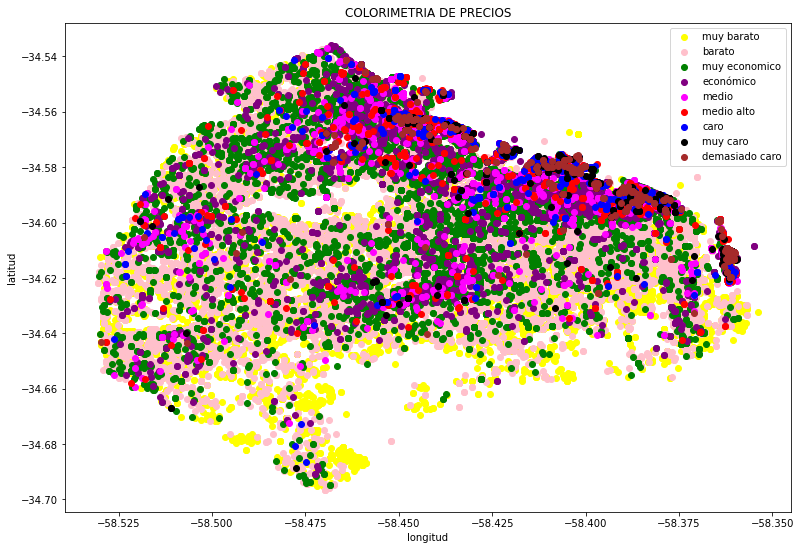

In [80]:
# creo un DataSet nuevo
df_plot=pd.DataFrame()

# Creo un ciclo para asignar al mismo tiempo colores y etiquetas
for colors,etiq in zip(colores, etiquetas):
    #filtrado de cada clase con su color respectivo
    df_plot=dataset[dataset['color']==colors]
    #plotear los datos en un grafico de dispersion
    plt.scatter(df_plot['lon'],df_plot['lat'],color=colors, label=etiq)
    # se crea un nuevo DataSet en cada iteracion 
    df_plot=pd.DataFrame()
plt.title('COLORIMETRIA DE PRECIOS')
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.legend()
plt.show()

#### Predominan en la zona central y norte de la ciudad los inmuebles mas caros, presentando algunas zonas donde se mezclan los mas costosos con los de precio medio, en cambio los mas baratos están distribuidos hacia la parte sur, formando una especie de cordón hacia las perifierias de la ciudad, tal como sucede en muchas ciudades del continente. Esto es indicativo de que es posible entrenar un modelo de predicción (con un grado de confiabilidad aceptable) usando como atributos la longitud y latitud de cada inmueble. El modelo que se va a entrenar debe predecir el precio de los inmuebles en la mayoría de las zonas con una precisión aceptable, en caso contrario deben realizarse las acciones de filtrado y depuracion de datos que mejoren este desempeño.

## Parte 5:<br>

---------------------------------------------------------------------------

#### Voy a proceder al escalado de los datos usando la tecnica de NORMALIZACION MEDIA, ya que es una de las formas más fáciles de normalizar los DataSets de rangos variados. Esto , se hace restando la media y dividiendo por la desviación estándar para todos los elementos del Dataframe.

In [81]:
# Para eso creo una pequeña funcion que hace esa tarea
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

#dataset2 es el mismo dataset sin la columna de rango porque este no es un atributo para entrenar el modelo
dataset2 = dataset.drop(['rango'], axis=1) #esto quita a la columna rango que noes numerica

#dataset2 es el mismo dataset sin la columna de color porque solo requerimos los atributos latitud y longitud
dataset2 = dataset2.drop(['color'], axis=1) #esto quita a la columna color que no es numerica

#Uso la funcion creada para normalizar el nuevo dataset
dataset_norm = mean_norm(dataset2)

print('----Dataset normalizado------')
print(dataset_norm.head())

----Dataset normalizado------
        lat       lon     price
0 -0.272268  1.420349 -0.422615
1 -1.030205  0.670210 -0.388077
2  0.241096  0.245890 -0.583792
3  0.752963 -0.010409  0.394781
5  0.232336 -0.134270 -0.439884


#### Voy a separar el dataset normalizado en Train (80%) y Test (20%).

In [82]:
# Separo el dataset en X_train, X_test, y_train e y_test con el tamaño correspondiente
X = dataset_norm.drop(['price'], axis=1) #esto quita a la columna target
y = dataset_norm['price']                #esta es la columna target

# Realizo la separación a continuación del conjunto de entrnamiento
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.2)

# imprimo las dimensiones de los conjuntos creados
print("Train test size: ", X_train.shape)
print("Test train size: ", X_test.shape)

Train test size:  (69288, 2)
Test train size:  (17322, 2)


#### En esta parte voy a Instanciar el modelo de estimacion o algoritmo que vamos a entrenar , en este caso se trata del algoritmo RandomForestRegressor. Seleccione este modelo porque necesito hacer una regresión (ya que nuestro target es una variable numero continua tipo float) y además segun lo investigado en la web puedo determinar que es uno de los algoritmos que mejor desempeño tiene cuando trabajamos con pocos atributos como es nuestro caso que solo tenemos 2 atributos.

In [83]:
# Creo el objeto o clase 
random_forest_model = RandomForestRegressor() # Instanciar el modelo de estimacion

# uso el metodo fit para entrenar
random_forest_model.fit(X_train , y_train) # Entrenando

RandomForestRegressor()

#### Ahora valido el modelo. Para validar Se toma como entrada el número de diferentes divisiones (pliegues) que se utilizarán (5 en el ejemplo a continuación) y se imprime el parametro score que indica la calidad que tendremos en la prediccion.

In [84]:
# Calculo el score
scores_random_forest = cross_val_score(random_forest_model, X, y, cv=5)

print(' ')
print(' Los resultados de la validacion cruzada para Random Forest es: ')
print(scores_random_forest)
print ("Accuracy_ Random Forest: %0.2f (+/- %0.2f)" % (scores_random_forest.mean(), scores_random_forest.std() / 2))

# Guardo el score de este modelo en la siguiente variable para despues compararlo con otro mejorado.
score_modelo1=scores_random_forest.mean()

 
 Los resultados de la validacion cruzada para Random Forest es: 
[0.66018401 0.67521496 0.65583559 0.61425463 0.71528511]
Accuracy_ Random Forest: 0.66 (+/- 0.02)


## Parte 6:<br>

---------------------------------------------------------------------------

#### Obtuve una precisión superior a la esperada por lo tanto puede utilizarse el modelo entrenado para predecir el precio de cualquier inmueble en la ciudad. Antes de realizar la Predicción , chequearemos los errores relativos. Para ello, primero vamos a crear una funcion que nos permita transformar los datos normalizados a la escala real en unidad monetaria, para ello creo la siguiente funcion.

In [85]:
# funcion para desnormalizar los valores y poder llevarlos a pesos Argentinos
def desnorm(dato_norm):
    desviacion=dataset2['price'].std()
    media=dataset2['price'].mean()
    dato_desnorm=dato_norm*desviacion+media
    return dato_desnorm #retorna el array en valores monetarios

#### Evaluo el cambio en el error relativo a medida que es más profundo el bosque, tanto en training como en testing.<br>

#### Para esto, se itera de 5 en 5 en el parámetro max_depth y vemos que sucede con el error relativo. Aqui creo dos listas donde voy a ir guardando los errores tanto del conjunto de entrenamiento como el de testeo

In [86]:
error_train = []
error_test= []

#### Defino una lista con los valores de profundidad que se quiere optimizar

In [87]:
depth =  [p for p in range(5,65,5)]

#### Se itera sobre la lista anterior y se calculan los errores de prediccion en cada caso

In [88]:
for value in depth:
    
    #asigno las profundidades al modelo
    modelo = RandomForestRegressor(max_depth=value)
    
    #entreno el modelo   
    modelo.fit(X_train, y_train) 
    
    ## Para el conjunto de testeo    
    #prediccion para X_test
    y_pred_test = modelo.predict(X_test) 
    #Transformo los datos a unidades monetarias
    y_pred_moneda=np.array(desnorm(y_pred_test))
    #Transformo los datos de testeo originales que habiamos normalizados a unidades monetarias
    y_test_moneda=desnorm(y_test)   
    # Calculo el error relativo
    error_relativo_test=np.array(100*abs(y_test_moneda-y_pred_moneda)/y_test_moneda)
    # Calculo el valor medio de los errores
    error_medio_test=error_relativo_test.mean()
    # Agrego la información a las listas de arriba
    error_test.append(error_medio_test)
    
    ## Para el conjunto de entrenamiento
    #predice sobre X_train, 
    y_pred_train = modelo.predict(X_train)
    #Transformo los datos a unidades monetarias
    y_pred_moneda=np.array(desnorm(y_pred_train))
    #Transformo los datos de entrenamiento originales que habiamos normalizados a unidades monetarias
    y_train_moneda=desnorm(y_train)
    # Calculo el error relativo
    error_relativo_train=np.array( 100*abs (y_train_moneda-y_pred_moneda)/y_train_moneda ) 
    error_medio_train=error_relativo_train.mean()    
    # Agrego la información a las listas de arriba    
    error_train.append(error_medio_train) #a

#### Ahora voy a graficar el error y decidir cual es el valor optimo del parametro "depth" del modelo. Esto se nota claramente cuando la grafica de errores tiende a estabilizarse.<br>



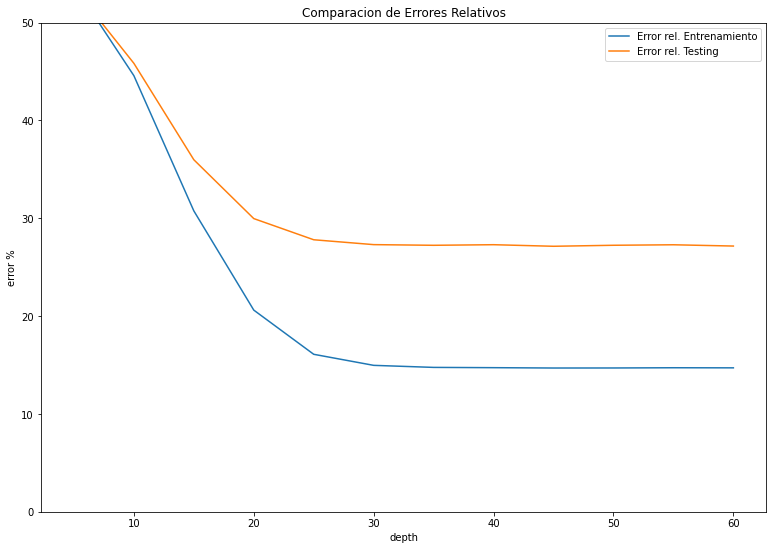

In [89]:
# Grafico
plt.plot(range(5,65, 5), error_train, label='Error rel. Entrenamiento')
plt.plot(range(5,65, 5), error_test, label='Error rel. Testing')
plt.ylim((0, 50))
plt.legend(loc="best")
plt.title("Comparacion de Errores Relativos")
plt.xlabel('depth')
plt.ylabel('error %')
plt.show()


#### Observando la grafica de errores , asumo que la profundidad "depth" optima del modelo es de 60, por eso este sera nuestro nuevo modelo.

In [90]:
modelo = RandomForestRegressor(max_depth=60)

## Parte 7:<br>

---------------------------------------------------------------------------

#### Ya tengo una precisión superior a la esperada y también he optimizado el valor de la profunidad del modelo, por lo tanto, solo falta analizar como se distribuyen los errores en cada una de las zonas del mapa. En tal sentido, voy a entrenar el modelo definitvo optimizado y calculare los errores relativos que se cometen cuando se predice todo el conjunto original completo. Para lograrlo, debo crear dos columnas nuevas en nuestro DataSet.<br>

#### Entreno el modelo una vez mas

In [91]:
modelo.fit(X,y)

RandomForestRegressor(max_depth=60)

In [92]:
# Creo la columna de precios predichos y de una vez los convertimos a unidades monetarias
dataset2['price_predict']= desnorm(modelo.predict(X))

# Ahora creo una columna llamada error relativo que contenga los errores de prediccion del conjunto
dataset2['error %']= abs(dataset2['price_predict']-dataset2['price'])*100/dataset2['price']

#### Presento el DataSet

In [93]:
dataset2.head()

lat        lon     price  price_predict       error %
0 -34.605880 -58.384949  153000.0  151321.613333  1.096985e+00
1 -34.624056 -58.412110  159000.0  169555.000000  6.638365e+00
2 -34.593569 -58.427474  125000.0  125000.000000  5.820766e-14
3 -34.581294 -58.436754  295000.0  290743.750000  1.442797e+00
5 -34.593779 -58.441239  150000.0  150000.000000  7.761021e-14

#### Para dar una explicacion grafica voy a representar en un mapa de dispersión los errores en cada zona de la Provincia. Aplicare el mismo procedimiento que use en el mapa de colores hecho con anterioridad

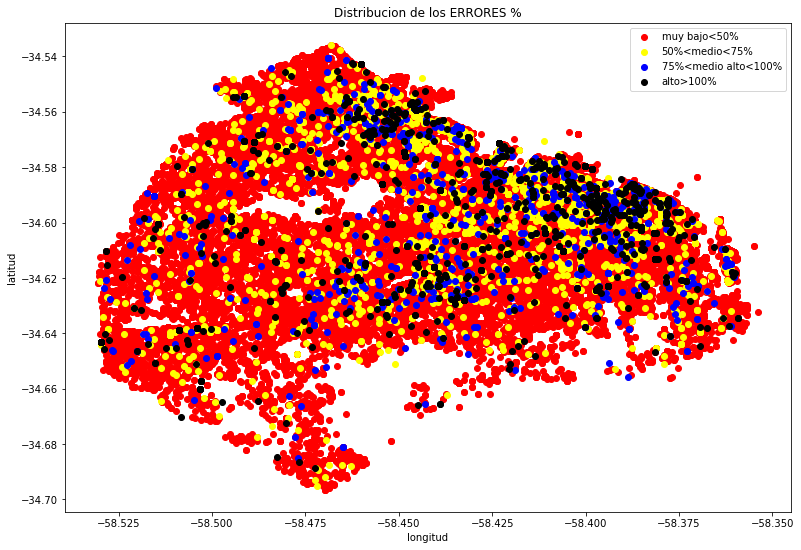

In [94]:
# creo la lista con los rangos limites para cada intervalo
bins=[0,50,75,100,200]# int for int in range(0,int(dataset2['error %'].max()), int(espaciado)) ]
# Agrupo las etiquetas correspondientes
etiquetas = ['muy bajo<50%', '50%<medio<75%', '75%<medio alto<100%', 'alto>100%']
# para graficar se usa la siguiente lista de colores 
colores=['red','yellow','blue','black'] 
# Defino rangos  como una nueva columna 
dataset2 ['rango'] = pd.cut ( dataset2['error %'], bins,
        right=False, labels=etiquetas)
# Defino una nueva columna que contiene el color para cada precio
dataset2 ['color'] = pd.cut ( dataset2['error %'], bins,
        right=False, labels=colores)
df_plot=pd.DataFrame()
# Creo un ciclo para asignar al mismo tiempo colores y etiquetas
for colors,etiq in zip(colores, etiquetas):
    #filtro de cada clase con su color respectivo
    df_plot=dataset2[dataset2['color']==colors]
    #ploteo los datos en una grafica de dispersion
    plt.scatter(df_plot['lon'],df_plot['lat'],color=colors, label=etiq)
    # Creo un nuevo dataFrame en cada iteracion 
    df_plot=pd.DataFrame() 
plt.title('Distribucion de los ERRORES %')
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.legend()
plt.show()

#### Existen zonas donde el error es muy bajo es decir menor al 50% y otras zonas donde el error es medio alto , es decir, esta en el intervalo 50% - 100%. Ademas se aprecia que existen zonas con alto porcentajes de errores relativos lo cual hace presumir que el modelo no es capaz de predecir el precio de los inmuebles en esas zonas. Se realizaran algunas modificaciones al dataset usado como entrenamiento, a fin de crear un nuevo modelo de predicción con una presición un poco mayor a la obtenida en este modelo.

## Parte 8:<br>

--------------------------------------------------------------------------- 

#### La estrategia propuesta consta de filtrar aquellos puntos o propiedades que presentan un error de prediccion alto o mayor al 50%. Voy a crear un nuevo DataSet solo con los puntos que entren en ese criterio y asumire que ese es nuestro nuevo dataset para entrenar nuestro modelo de nuevo.

In [95]:
# creo el modelo optimizado
modelo_opt = RandomForestRegressor(max_depth=60)
# filtro puntos con error menor a 50%
df2=dataset2[dataset2['error %']<50]
df3=df2.copy() #creo una copia de este dataframe 
# lista que contiene las columnas a eliminar 
columnas_eliminar=['price_predict','error %','rango','color']
# ciclo para ir eliminando cada columna que no queremos tener 
for col in columnas_eliminar:
    data_final = df2.drop([col], axis=1) #esto quita a la columna target
    df2=data_final
# elimino el precio para tener a X train
X = data_final.drop(['price'], axis=1)
# defino el target
y=data_final['price']
# entreno el modelo con este nuevo dataset de puntos con bajo error
modelo_opt.fit(X,y)

RandomForestRegressor(max_depth=60)

#### Vuelvo a Calcular el Score

In [96]:
# Calculo el score
scores_random_forest = cross_val_score(modelo_opt, X, y, cv=5)

print(' ')
print(' Los resultados de la validacion cruzada para Random Forest es: ')
print(scores_random_forest)
print ("Accuracy_ Random Forest: %0.2f (+/- %0.2f)" % (scores_random_forest.mean(), scores_random_forest.std() / 2))
# Vamos a guardar el score de este modelo en la siguiente variable para despuesta compararlo con otro mejorado
score_modelo2=scores_random_forest.mean()

 
 Los resultados de la validacion cruzada para Random Forest es: 
[0.75239902 0.76386028 0.73877255 0.69836434 0.79168449]
Accuracy_ Random Forest: 0.75 (+/- 0.02)


#### Grafico mediante un Barplot la mejora en el score entre los dos modelos

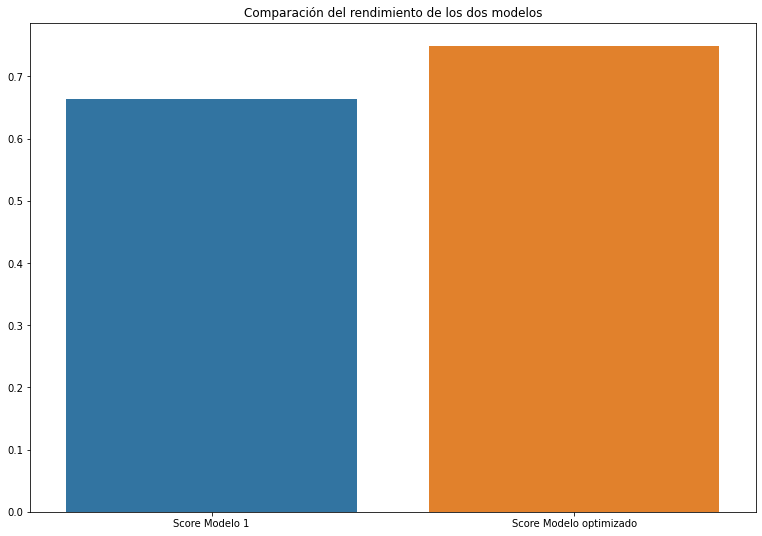

In [97]:
x = ['Score Modelo 1', 'Score Modelo optimizado']
y = [score_modelo1, score_modelo2]

#Genero el grafico de barras
sns.barplot(x, y).set_title('Comparación del rendimiento de los dos modelos')

plt.show()

#### La precisión es mucho mejor ya que se incremento al 74%, voy ahora a generar las nuevas columnas de predicción y de cálculo de los nuevos errores relativos con el nuevo dataset.

In [98]:
# nueva columna con los valores predichos con el nuevo modelo mejorado
df3['price_predict_2']= (modelo_opt.predict(X)) 
# nueva columna con los valores del error relativoredichos con el nuevo modelo mejprado
df3['error 2 %']= abs(df3['price_predict_2']-df3['price'])*100/df3['price']
df3.head()

lat        lon     price  price_predict       error %         rango  \
0 -34.605880 -58.384949  153000.0  151321.613333  1.096985e+00  muy bajo<50%   
1 -34.624056 -58.412110  159000.0  169555.000000  6.638365e+00  muy bajo<50%   
2 -34.593569 -58.427474  125000.0  125000.000000  5.820766e-14  muy bajo<50%   
3 -34.581294 -58.436754  295000.0  290743.750000  1.442797e+00  muy bajo<50%   
5 -34.593779 -58.441239  150000.0  150000.000000  7.761021e-14  muy bajo<50%   

  color  price_predict_2  error 2 %  
0   red    152878.970952   0.079104  
1   red    172992.000000   8.800000  
2   red    125000.000000   0.000000  
3   red    303625.000000   2.923729  
5   red    150000.000000   0.000000

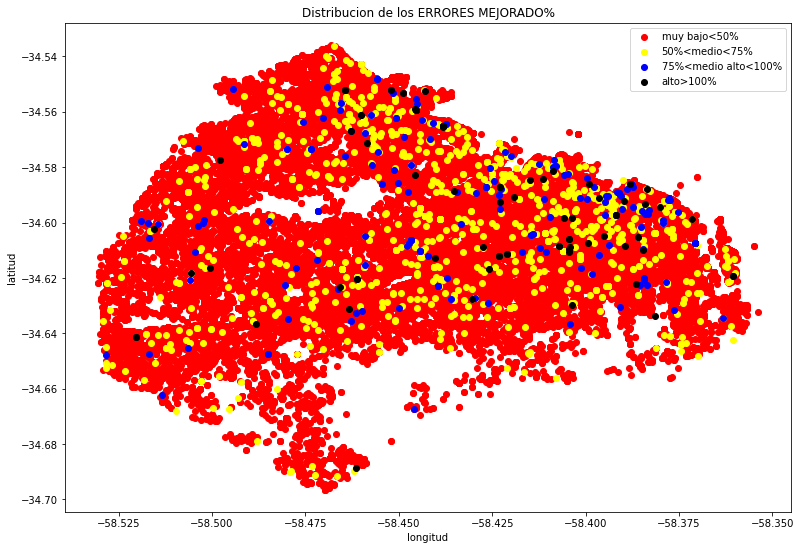

In [99]:
# creo la lista con los rangos limites para cada intervalo
bins=[0,50,75,100,200]# int for int in range(0,int(dataset2['error %'].max()), int(espaciado)) ]
# Agrupo las etiquetas correspondientes
etiquetas = ['muy bajo<50%', '50%<medio<75%', '75%<medio alto<100%', 'alto>100%']
# para graficar se usara la siguiente lista de colores 
colores=['red','yellow','blue','black'] 
# Defino rangos  como una nueva columna 
df3 ['rango2'] = pd.cut ( df3['error 2 %'], bins,
        right=False, labels=etiquetas)
# Defino una nueva columna que contiene el color para cada precio
df3 ['color2'] = pd.cut ( df3['error 2 %'], bins,
        right=False, labels=colores)
df_plot=pd.DataFrame()
# Creo un ciclo para asignar al mismo tiempo colores y etiquetas
for colors,etiq in zip(colores, etiquetas):
    #filtro de cada clase con su color respectivo
    df_plot=df3[df3['color2']==colors]
    #plotear los datos en una grafica de dispersion
    plt.scatter(df_plot['lon'],df_plot['lat'],color=colors, label=etiq)
    # Creo un nuevo DataSet en cada iteracion 
    df_plot=pd.DataFrame() 
plt.title('Distribucion de los ERRORES MEJORADO%')
plt.xlabel('longitud')
plt.ylabel('latitud')
plt.legend()
plt.show()

#### Se observa una reducción de la distribución de los errores, predominando los colores rojo y amarillo, lo cual quiere decir que este nuevo modelo depurado y optimizado ofrece mejor desempeño para predecir el precio de cualquier propiedad. Se han depurado muchos de los puntos negros y azules que aparecian en el gráfico del modelo anterior, los cuales representaban errores muy altos.

## Parte 9:<br>

--------------------------------------------------------------------------- 

#### Punto A (longitud=-58.526, Latitud=-34.626) y Punto B (longitud=-58.377, Latitud=-34.633) <br>

#### Para calcular el precio de estas propiedades, simplemente creo un DataFrame con las coordenadas que nos dan en cada caso (A y B) y esa será nuestra x a predecir con el modelo optimizado.

In [100]:
# Para el punto A
xA=pd.DataFrame()
# Vacio las coordenadas de A
xA['lat']=[-34.626]
xA['lon']=[-58.526]

In [101]:
# Hago la prediccion con el modelo optimizado
yA=modelo_opt.predict(xA)
print('El precio de la propiedad A es de: $ ', int(yA[0]))

El precio de la propiedad A es de: $  315691


In [102]:
#Para el punto B
xB=pd.DataFrame()
# Vaciamos las coordenadas de A
xB['lat']=[-34.633]
xB['lon']=[-58.377]

In [103]:
# hacemos la prediccion con el modelo optimizado
yB=modelo_opt.predict(xB)
print('El precio de la propiedad B es de: $ ', int(yB[0]))

El precio de la propiedad B es de: $  284152
